# Classic Deep Learning Seed Value 7
Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed 
set_random_seed(7)
from math import ceil
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize #, preprocess_input

import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils, to_categorical, plot_model
from keras.applications import imagenet_utils, resnet50, resnet
from keras.applications import resnext
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
#from kerastuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Average, Concatenate
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.backend import clear_session
#free GPU memory
clear_session()
from datetime import datetime

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

In [2]:
import tensorflow  as tf
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()


## Introduction

This notebook contains the code for image classification using classic Deep Learning by random initialisation of the built-in ResNet50 and EfficientNetB4 models. A new *random_state* or *seed* value of 7 is used in determining the data splits.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed.

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

(224, 224, 6, 1440)


In [5]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [6]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


In [7]:
#Scale the disp, ph and coh bands to 0 to 255
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))
X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

max, min 3.1391279697418213 -3.1403708457946777
band input shape (1440, 3, 224, 224)
scale band data shape (224, 224, 3, 1440)
scale band data reshaped (1440, 150528)
band output shape (1440, 3, 224, 224)
max, min 255.00000000000006 0.0


In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.00000000000006 0.0


In [9]:
#Reshape to Keras desired shape
X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

(1440, 224, 224, 6)


## Classification

Classic deep learning classifiers are implemented below using the built-in ResNet50 and EfficientNetB4 models by training from scratch i.e. Random Initialisation.

In [10]:
#Below code for multiple generator adapted from: https://github.com/keras-team/keras/issues/8130 
def multi_gen(generator, X, Y, batch_size, img_height,img_width):    
    gen_X0 = generator.flow(X[0], Y, batch_size = batch_size, shuffle=False, seed=7)    
    gen_X1 = generator.flow(X[1], batch_size = batch_size, shuffle=False, seed=7)
    
    while True:
            X0 = gen_X0.next()
            X1 = gen_X1.next()
            #Yield the 2 x 3 channel inputs and their mutual label
            #Had to rename input_2 to input_2_2 when renaming all layers in resnet_2
            yield ({'input_1': X0[0], 'input_2_2': X1[0]}, {'output': X0[1]})

#Below timing code adapted from: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHist(Callback):
    def at_train_start(self, logs={}):
        self.times = []

    def at_epoch_start(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def at_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
#Setup single models
def singleModel(img_res, model_str, X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test, y_train, y_val, 
                y_test, train_index, val_index, single_model_name_str, results_arr, dropout, counter):
    
    #For fine tuning set to 'imagenet'
    weights_str = None
        
    img_h = img_res
    img_w = img_res
    batch_Size = 10
    
    print(single_model_name_str)
    X_band_train = X_band_train_val[train_index].copy()
    X_band_val = X_band_train_val[val_index].copy()
    X_band_test = X_band_test.copy()
    X_rgb_train = X_rgb_train_val[train_index].copy()
    X_rgb_val = X_rgb_train_val[val_index].copy()
    X_rgb_test = X_rgb_test.copy()
    print('Band: Train: ', X_band_train.shape, 'Validation:', X_band_val.shape, 'Test:', X_band_test.shape)         
    print('RGB: Train: ', X_rgb_train.shape, 'Validation:', X_rgb_val.shape, 'Test:', X_rgb_test.shape)         
    del X_band_train_val, X_rgb_train_val
    
    if model_str == 'ResNet50':
        print("\n ResNet model \n")
        net_1 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 171 #168 
    elif model_str == 'EffNetB4':
        print("\n EfficientNet model \n")
        net_1 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 464 #460

    print(model_str + ' 1 input shape:', net_1.input.shape)
    print(model_str + ' 1 output shape:', net_1.output.shape)

    training_size = X_band_train.shape[0]
    validating_size = X_band_val.shape[0]
    testing_size = X_band_test.shape[0]

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    for layer in net_2.layers:
        layer.name = layer.name + str('_2')

    preds1 = net_1.output
    preds1 = GlobalAveragePooling2D()(preds1)
    preds1 = Dropout(dropout)(preds1)
    #preds1 = Dense(512, activation='relu',)(preds1)
    #preds1 = Dropout(dropout)(preds1)
    preds1 = Dense(2, activation='softmax', name='Softmax_1')(preds1)
    preds2 = net_2.output
    preds2 = GlobalAveragePooling2D()(preds2)
    preds2 = Dropout(dropout)(preds2)
    #preds2 = Dense(512, activation='relu',)(preds2)
    #preds2 = Dropout(dropout)(preds2)
    preds2 = Dense(2, activation='softmax', name='Softmax_2')(preds2)
    preds = Average()([preds1, preds2])

    cnn_model = Model(inputs = [net_1.input, net_2.input], outputs = preds, name='ensemble')

    #optim = Adam(lr=0.0001)
    #optim = 'Adam'
    #optim = SGD(lr=1e-3, momentum=0.9, decay=1e-3/25)
    optim = SGD(lr=1e-4, momentum=0.9)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])
    time_callback = TimeHist()
    chkpt_path = './model/' + single_model_name_str + '_RI_bestmodel.hdf5'
    checkpointer = ModelCheckpoint(filepath=chkpt_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)                

    input_imgen = ImageDataGenerator(shear_range = 0.30, zoom_range = 0.30, width_shift_range=0.3, 
                height_shift_range=0.3, rotation_range = 60, horizontal_flip = True, fill_mode='nearest')
    val_imgen = ImageDataGenerator()
    test_imgen = ImageDataGenerator()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto', 
                                 min_lr=0.000001)
    callbacks_list = [checkpointer, time_callback, reduceLR, es,]
    
    train_generator = input_imgen.flow([X_band_train.copy(), X_rgb_train.copy()], y_train.copy(), 
                    batch_size=batch_Size, shuffle=False)
    val_generator = val_imgen.flow([X_band_val.copy(), X_rgb_val.copy()], y_val.copy(), batch_size=batch_Size, shuffle=False)
    test_generator = test_imgen.flow([X_band_test.copy(), X_rgb_test.copy()], batch_size=batch_Size, shuffle=False)
    
    history = cnn_model.fit_generator(train_generator, steps_per_epoch=round(training_size/batch_Size), epochs = 50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    test_preds = cnn_model.predict_generator(test_generator, steps=round(testing_size/batch_Size))
        
    #load the saved model
    saved_model = load_model(chkpt_path)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    train_preds = saved_model.predict_generator(train_generator, steps = round(training_size/batch_Size))
    val_preds = saved_model.predict_generator(val_generator, steps = ceil(validating_size/batch_Size))
    
    test_preds = saved_model.predict_generator(test_generator, steps = round(testing_size/batch_Size))
    print('validating_size', validating_size, 'val_preds', val_preds.shape, 'y_val: ', y_val.shape)
    
    val_acc = round(accuracy_score(np.argmax(y_val.copy(), axis=1), np.argmax(val_preds.copy(), axis=1))*100, 2)
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    print(single_model_name_str + ' : Counter: %i, Accuracies: Validation: %.2f %%, Test: %.2f %%' % (counter, 
            val_acc, test_acc))

    if counter == 0:
        plot_model(cnn_model, to_file= './model/' + single_model_name_str + '_Simple_NN_Architecture.png')
    
    #Visualisation code from Keras API dcumentation: https://keras.io/visualization/
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_RI_Accuracy_' + str(counter) + '.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_RI_Loss_' + str(counter) + '.png')
    plt.show()

    del history, saved_model, cnn_model
    
    results_arr.append(val_acc)
    results_arr.append(test_acc)     
    results_arr = evaluator(np.round(np.argmax(test_preds.copy(),axis=1)), np.argmax(y_test.copy(), axis=1), results_arr)
    
    del X_band_train, X_rgb_train, X_band_val, X_rgb_val, y_train, y_val, y_test, X_band_test, X_rgb_test
    clear_session()
    del net_1, net_2, train_preds 
    return val_preds, test_preds, results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(val_preds, test_preds, y_val, y_test, ensemble_str, results_arr):
    val_preds = np.mean(val_preds, axis=0)
    test_preds = np.mean(test_preds, axis=0)
    ensemble_preds_val = np.argmax(val_preds, axis=1)
    ensemble_preds_test = np.argmax(test_preds, axis=1)
    ensemble_val_acc = np.round(accuracy_score(y_val, np.round(ensemble_preds_val))*100, 2)
    print('Validation score of ' + ensemble_str + ': ', ensemble_val_acc, '%')
    ensemble_test_acc = np.round(accuracy_score(y_test.copy(), np.round(ensemble_preds_test))*100, 2)
    print('Test score of ' + ensemble_str + ': ', ensemble_test_acc, '%')
     
    results_arr.append(ensemble_val_acc)
    results_arr.append(ensemble_test_acc)
    results_arr = evaluator(np.round(ensemble_preds_test.copy()), y_test.copy(), results_arr)
    return results_arr

In [12]:
#Function to train model 
def trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test, 
               y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test):
        
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=7)
    sss.get_n_splits(X_resnet50_band_train_val, y_train_val)

    dropout=[0.2, 0.3, 0.4]
    single_model_name = ['ResNet50 RI Seed 7 Dropout: ' + str(dropout[0]), 'ResNet50 RI Seed 7 Dropout: ' + str(dropout[1]), 
                         'ResNet50 RI Seed 7 Dropout: ' + str(dropout[2]), 'EfficientNet B4 RI Seed 7 Dropout: ' + str(dropout[0]),
                        'EfficientNet B4 RI Seed 7 Dropout: ' + str(dropout[1]), 'EfficientNet B4 RI Seed 7 Dropout: ' + str(dropout[2]),]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    
    ensemble_names = ['Ensemble of 1 & 2 Seed 7 RI',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
    
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []
    
    counter = 0
    for train_index, val_index in sss.split(X_resnet50_band_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('Counter: ', counter, '\n', datetime.now())
        
        results_arr.append(counter)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
        
        # Model 1 ResNet50 Fine Tuning
        preds_1, test_preds_1, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, dropout[0], counter)
        
        preds_2, test_preds_2, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, dropout[1], counter)

        preds_3, test_preds_3, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, dropout[2], counter)
        
        # Model 2 EfficientNet B4 Fine Tuning
        preds_4, test_preds_4, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[3], results_arr, dropout[0], counter)
                    
        preds_5, test_preds_5, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[4], results_arr, dropout[1], counter)
                    
        preds_6, test_preds_6, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[5], results_arr, dropout[2], counter)
        
        #Ensembling
        val_preds = np.stack((preds_1, preds_2))
        test_preds = np.stack((test_preds_1, test_preds_2))
        results_arr = ensembler(val_preds, test_preds, y_val.copy(), y_test.copy(), ensemble_names[0], results_arr)
           
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        counter = counter + 1
        del y_train, y_val, 
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    del X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test
    del X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test
    return results_data

2021-08-15 08:57:10.621719 
 X, y shapes:  (1440, 224, 224, 6) (1440,)
X_resnet50_band_train_val processed: max, min 151.061 -123.68
X_resnet50_rgb_train_val processed: max, min 151.061 -123.68
X_resnet50_band_test processed: max, min 151.061 -123.68
X_resnet50_rgb_test processed: max, min 151.061 -123.68
X_effnet_bands_train_val processed: max, min 2.64 -2.117904
X_effnet_rgb_train_val processed: max, min 2.64 -2.117904
X_effnet_bands_test processed: max, min 2.64 -2.117904
X_effnet_rgb_test processed: max, min 2.64 -2.117904
Model 1: ResNet50 RI Seed 7 Dropout: 0.2
Model 2: ResNet50 RI Seed 7 Dropout: 0.3
Model 3: ResNet50 RI Seed 7 Dropout: 0.4
Model 4: EfficientNet B4 RI Seed 7 Dropout: 0.2
Model 5: EfficientNet B4 RI Seed 7 Dropout: 0.3
Model 6: EfficientNet B4 RI Seed 7 Dropout: 0.4
Overlap set()
Counter:  0 
 2021-08-15 08:57:49.927781
ResNet50 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 

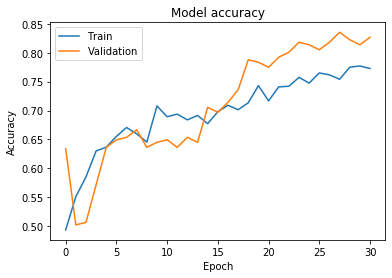

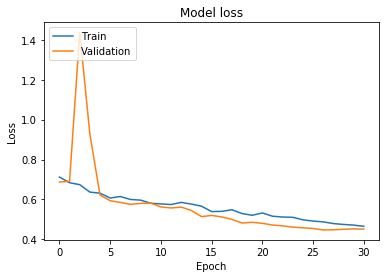

F1 score is:  0.79
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[110  34]
 [ 25 119]]
From the confusion matrix above there are 110 true negatives and 34 false positives.
There are 25 false negatives and 119 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 44s 473ms/step - loss: 0.7429 - acc: 0.4967 - val_loss: 0.6936 - val_acc: 0.4610

Epoch 00001: val_loss improved from inf to 0.69360, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6931 - acc: 0.5054 - val_loss: 0.6907 - val_acc: 0.5541

Epoch 00002: val_loss improved from 0.69360 to 0.

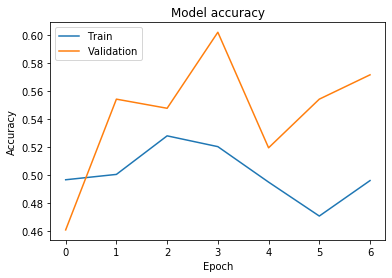

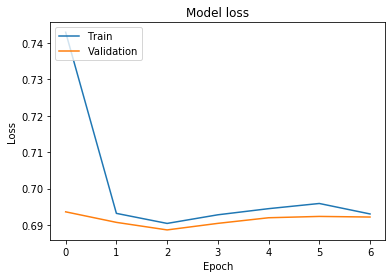

F1 score is:  0.56
Recall score is:  0.65
Precision score is:  0.6
Confusion matrix: 
 [[129  15]
 [101  43]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 101 false negatives and 43 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 44s 477ms/step - loss: 0.7095 - acc: 0.5837 - val_loss: 0.6817 - val_acc: 0.6320

Epoch 00001: val_loss improved from inf to 0.68170, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 311ms/step - loss: 0.6829 - acc: 0.6153 - val_loss: 0.6722 - val_acc: 0.6861

Epoch 00002: val_loss improved from 0.68170 to 0

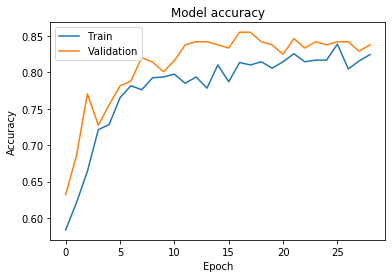

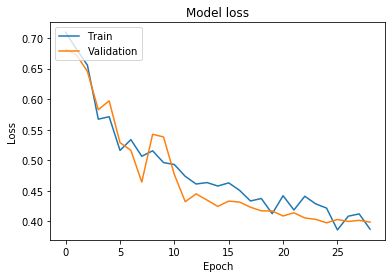

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[124  20]
 [ 32 112]]
From the confusion matrix above there are 124 true negatives and 20 false positives.
There are 32 false negatives and 112 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 101s 1s/step - loss: 0.6800 - acc: 0.5674 - val_loss: 0.6997 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.69974, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 715ms/step - loss: 0.6749 - acc: 0.6000 - val_loss: 0.6936 - val_acc: 0.5455

Epoch 00002: val_loss improve

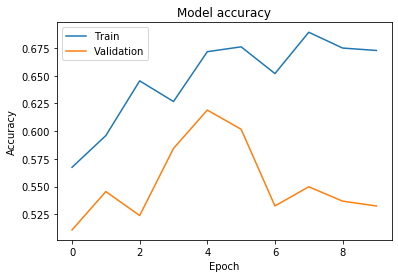

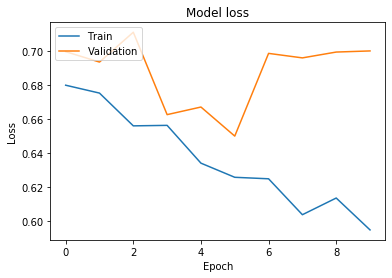

F1 score is:  0.61
Recall score is:  0.77
Precision score is:  0.65
Confusion matrix: 
 [[141   3]
 [ 97  47]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 97 false negatives and 47 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7047 - acc: 0.5283 - val_loss: 0.6916 - val_acc: 0.5758

Epoch 00001: val_loss improved from inf to 0.69162, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 706ms/step - loss: 0.6687 - acc: 0.5934 - val_loss: 0.7865 - val_acc: 0.6623

Epoch 00002: val_loss did not im

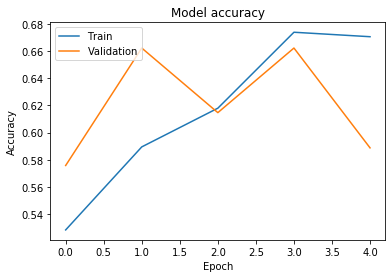

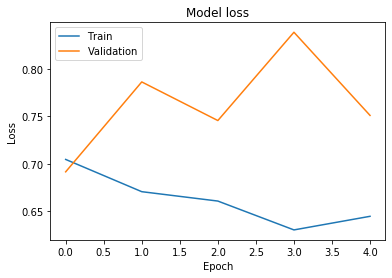

F1 score is:  0.56
Recall score is:  0.66
Precision score is:  0.6
Confusion matrix: 
 [[130  14]
 [102  42]]
From the confusion matrix above there are 130 true negatives and 14 false positives.
There are 102 false negatives and 42 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6881 - acc: 0.5380 - val_loss: 0.6612 - val_acc: 0.6190

Epoch 00001: val_loss improved from inf to 0.66117, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 701ms/step - loss: 0.6419 - acc: 0.6260 - val_loss: 0.6366 - val_acc: 0.6450

Epoch 00002: val_loss improved 

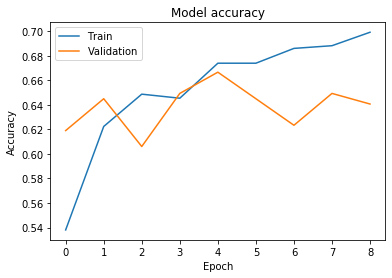

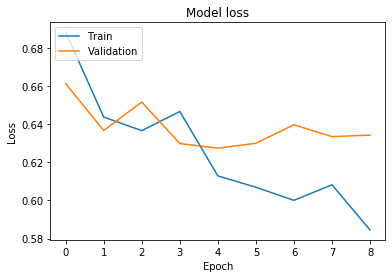

F1 score is:  0.65
Recall score is:  0.77
Precision score is:  0.68
Confusion matrix: 
 [[139   5]
 [ 88  56]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 88 false negatives and 56 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  82.68 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  79.86 %
F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[113  31]
 [ 27 117]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 27 false negatives and 117 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   

   ResNet50 RI Seed 7 Dropout: 0.2 Test Acc  \
0                                     79.51   

   ResNet50 RI Seed 7 Dropout: 0.2 F1 score  \
0                                      0.79   

   ResNet50 RI Seed 7 Dropout: 0.2 Precision  \
0                             

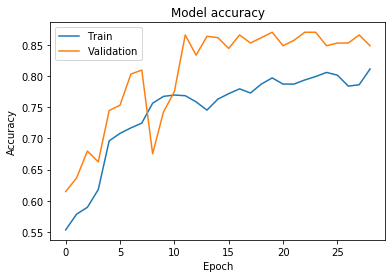

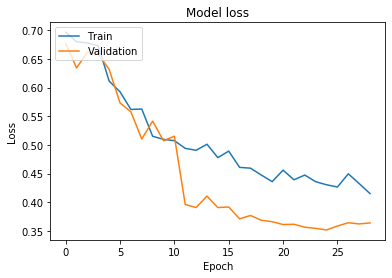

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[118  26]
 [ 24 120]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 24 false negatives and 120 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 470ms/step - loss: 0.7209 - acc: 0.4870 - val_loss: 0.6934 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.69341, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6940 - acc: 0.5217 - val_loss: 0.6907 - val_acc: 0.5584

Epoch 00002: val_loss improved from 0.69341 to 

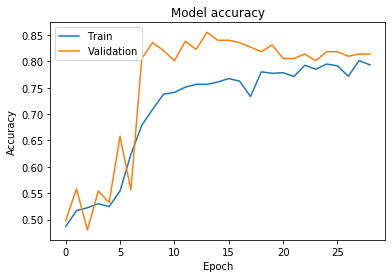

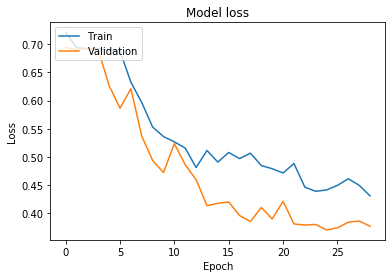

F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[113  31]
 [ 23 121]]
From the confusion matrix above there are 113 true negatives and 31 false positives.
There are 23 false negatives and 121 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7284 - acc: 0.5272 - val_loss: 0.6925 - val_acc: 0.6667

Epoch 00001: val_loss improved from inf to 0.69251, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 31s 339ms/step - loss: 0.6886 - acc: 0.5934 - val_loss: 0.6881 - val_acc: 0.7294

Epoch 00002: val_loss improved from 0.69251 to 

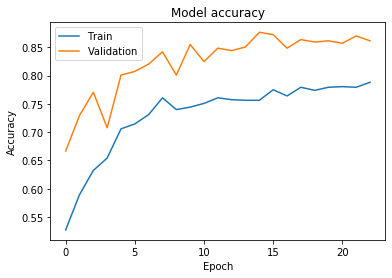

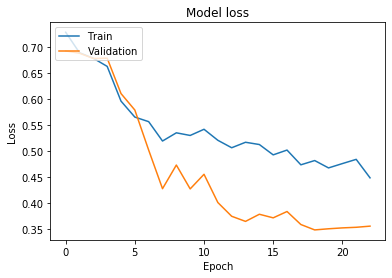

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[122  22]
 [ 36 108]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 36 false negatives and 108 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 101s 1s/step - loss: 0.6745 - acc: 0.5891 - val_loss: 0.6953 - val_acc: 0.5455

Epoch 00001: val_loss improved from inf to 0.69535, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 67s 723ms/step - loss: 0.6634 - acc: 0.5946 - val_loss: 0.6806 - val_acc: 0.5909

Epoch 00002: val_loss improved f

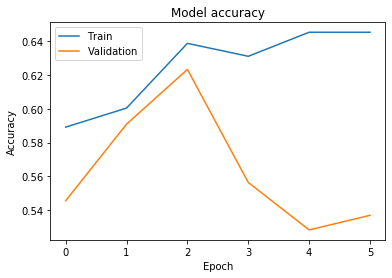

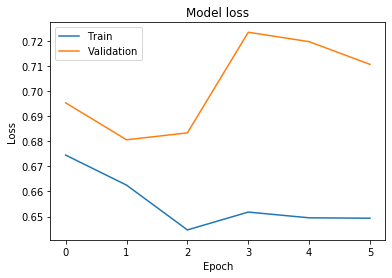

F1 score is:  0.53
Recall score is:  0.72
Precision score is:  0.6
Confusion matrix: 
 [[140   4]
 [112  32]]
From the confusion matrix above there are 140 true negatives and 4 false positives.
There are 112 false negatives and 32 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 100s 1s/step - loss: 0.6979 - acc: 0.5207 - val_loss: 0.7556 - val_acc: 0.6277

Epoch 00001: val_loss improved from inf to 0.75564, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 718ms/step - loss: 0.6775 - acc: 0.5826 - val_loss: 0.7353 - val_acc: 0.5325

Epoch 00002: val_loss improved 

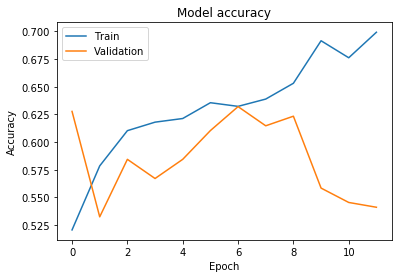

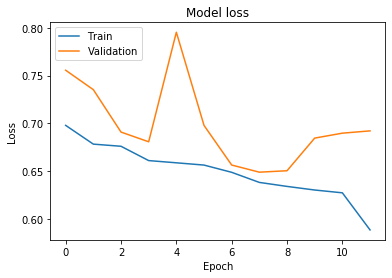

F1 score is:  0.62
Recall score is:  0.75
Precision score is:  0.66
Confusion matrix: 
 [[139   5]
 [ 93  51]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 93 false negatives and 51 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 100s 1s/step - loss: 0.6766 - acc: 0.6087 - val_loss: 0.6542 - val_acc: 0.6061

Epoch 00001: val_loss improved from inf to 0.65422, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 710ms/step - loss: 0.6711 - acc: 0.6217 - val_loss: 0.6372 - val_acc: 0.6450

Epoch 00002: val_loss improved 

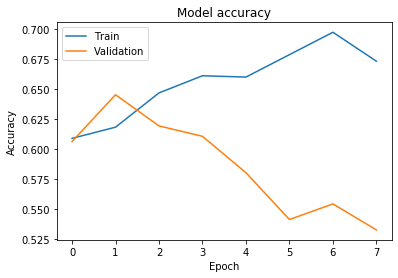

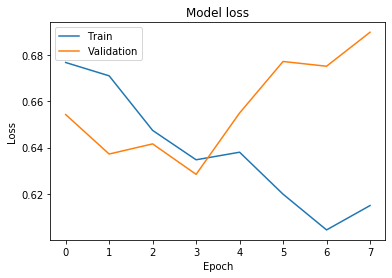

F1 score is:  0.61
Recall score is:  0.78
Precision score is:  0.65
Confusion matrix: 
 [[142   2]
 [ 98  46]]
From the confusion matrix above there are 142 true negatives and 2 false positives.
There are 98 false negatives and 46 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  83.55 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  82.99 %
F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[117  27]
 [ 22 122]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 22 false negatives and 122 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   

   ResNet50 RI Seed 7 Dropout: 0.2 Test Acc  \
0                                     79.51   
1                                     82.64   

   ResNet50 RI Seed 7 Dropout: 0.2 F1 score  \
0                     

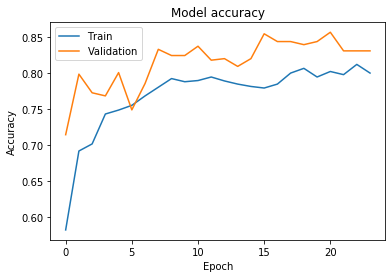

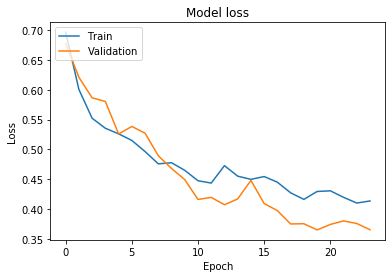

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[123  21]
 [ 37 107]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 37 false negatives and 107 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7034 - acc: 0.5424 - val_loss: 0.6893 - val_acc: 0.7338

Epoch 00001: val_loss improved from inf to 0.68927, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 318ms/step - loss: 0.6888 - acc: 0.5510 - val_loss: 0.6889 - val_acc: 0.5779

Epoch 00002: val_loss improved from 0.68927 to 0.6

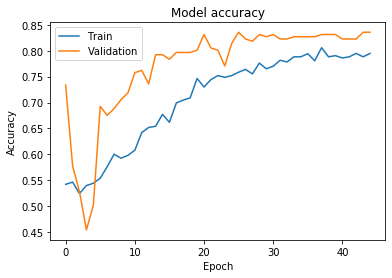

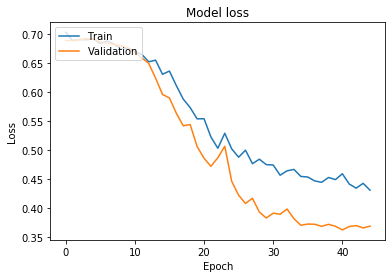

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[120  24]
 [ 28 116]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 28 false negatives and 116 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 471ms/step - loss: 0.7830 - acc: 0.5315 - val_loss: 0.7291 - val_acc: 0.4589

Epoch 00001: val_loss improved from inf to 0.72914, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 30s 329ms/step - loss: 0.6966 - acc: 0.5272 - val_loss: 0.6814 - val_acc: 0.4978

Epoch 00002: val_loss improved from 0.72914 to 

Epoch 34/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5811 - acc: 0.7141 - val_loss: 0.4976 - val_acc: 0.7532

Epoch 00034: val_loss improved from 0.50979 to 0.49762, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 35/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5709 - acc: 0.6945 - val_loss: 0.4999 - val_acc: 0.7576

Epoch 00035: val_loss did not improve from 0.49762
Epoch 36/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5762 - acc: 0.7152 - val_loss: 0.4929 - val_acc: 0.7576

Epoch 00036: val_loss improved from 0.49762 to 0.49288, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 37/50
92/92 [==============================] - 29s 315ms/step - loss: 0.5717 - acc: 0.7108 - val_loss: 0.5047 - val_acc: 0.7446

Epoch 00037: val_loss did not improve from 0.49288
Epoch 38/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5896 - acc: 0.6892 -

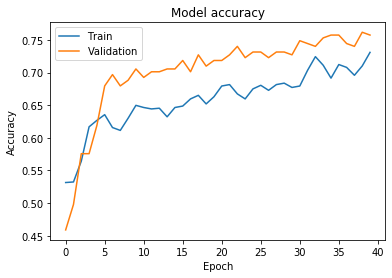

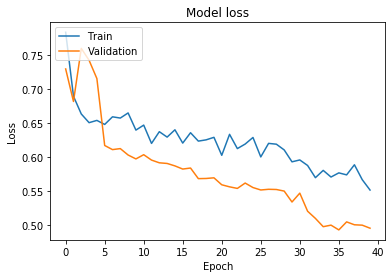

F1 score is:  0.73
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[ 94  50]
 [ 26 118]]
From the confusion matrix above there are 94 true negatives and 50 false positives.
There are 26 false negatives and 118 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6921 - acc: 0.5380 - val_loss: 0.6580 - val_acc: 0.6104

Epoch 00001: val_loss improved from inf to 0.65798, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 709ms/step - loss: 0.6774 - acc: 0.5848 - val_loss: 0.7128 - val_acc: 0.5238

Epoch 00002: val_loss did not i

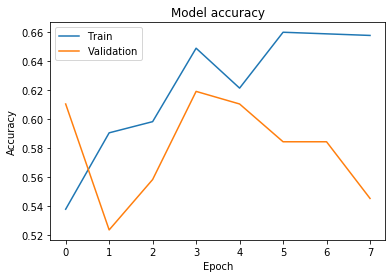

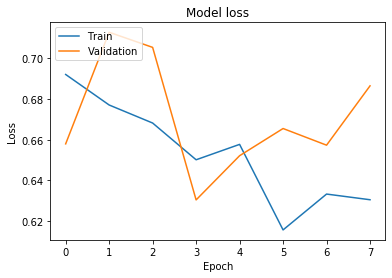

F1 score is:  0.62
Recall score is:  0.75
Precision score is:  0.66
Confusion matrix: 
 [[138   6]
 [ 93  51]]
From the confusion matrix above there are 138 true negatives and 6 false positives.
There are 93 false negatives and 51 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6827 - acc: 0.5435 - val_loss: 0.6694 - val_acc: 0.5628

Epoch 00001: val_loss improved from inf to 0.66940, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 721ms/step - loss: 0.6702 - acc: 0.5892 - val_loss: 0.6902 - val_acc: 0.5455

Epoch 00002: val_loss did not im

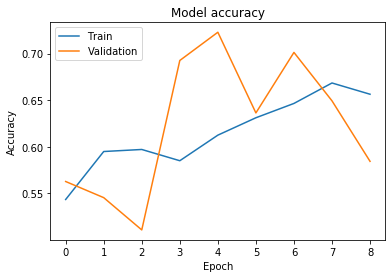

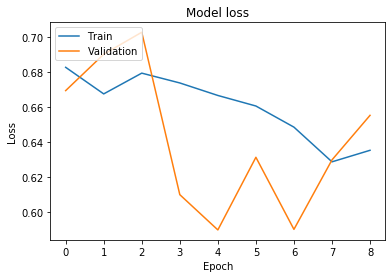

F1 score is:  0.72
Recall score is:  0.78
Precision score is:  0.73
Confusion matrix: 
 [[135   9]
 [ 68  76]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 68 false negatives and 76 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6945 - acc: 0.5011 - val_loss: 0.6955 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.69553, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 695ms/step - loss: 0.6554 - acc: 0.6109 - val_loss: 0.6825 - val_acc: 0.5411

Epoch 00002: val_loss improved f

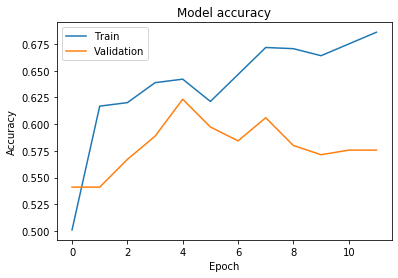

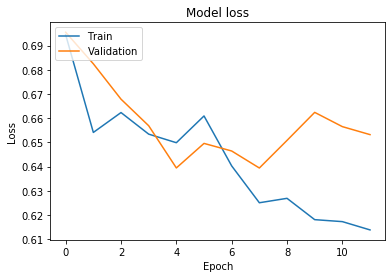

F1 score is:  0.54
Recall score is:  0.74
Precision score is:  0.6
Confusion matrix: 
 [[141   3]
 [111  33]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 111 false negatives and 33 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  84.85 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  79.86 %
F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[123  21]
 [ 37 107]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 37 false negatives and 107 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   

   ResNet50 RI Seed 7 Dropout: 0.2 Test Acc  \
0                                     79.51   
1                                     82.64   
2                  

validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 RI Seed 7 Dropout: 0.2 : Counter: 3, Accuracies: Validation: 77.06 %, Test: 77.43 %


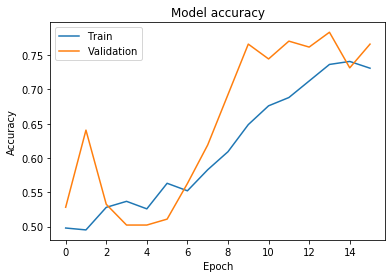

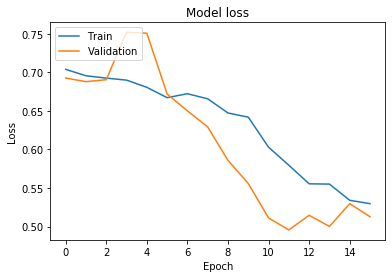

F1 score is:  0.77
Recall score is:  0.78
Precision score is:  0.77
Confusion matrix: 
 [[102  42]
 [ 23 121]]
From the confusion matrix above there are 102 true negatives and 42 false positives.
There are 23 false negatives and 121 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 44s 474ms/step - loss: 0.7103 - acc: 0.4978 - val_loss: 0.6918 - val_acc: 0.5931

Epoch 00001: val_loss improved from inf to 0.69179, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 30s 325ms/step - loss: 0.6942 - acc: 0.5152 - val_loss: 0.6929 - val_acc: 0.5693

Epoch 00002: val_loss did not improve from 0.69

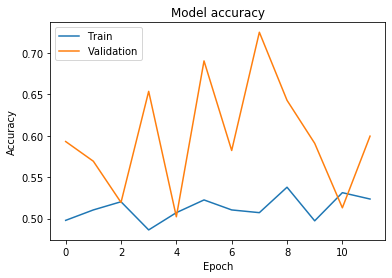

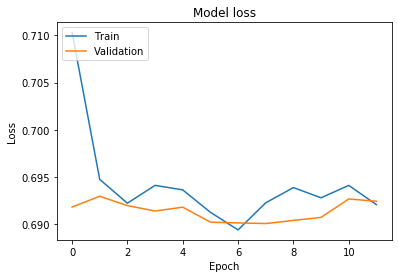

F1 score is:  0.74
Recall score is:  0.77
Precision score is:  0.75
Confusion matrix: 
 [[129  15]
 [ 57  87]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 57 false negatives and 87 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 470ms/step - loss: 0.7222 - acc: 0.5054 - val_loss: 0.6904 - val_acc: 0.5541

Epoch 00001: val_loss improved from inf to 0.69042, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 316ms/step - loss: 0.6959 - acc: 0.5119 - val_loss: 0.6924 - val_acc: 0.5455

Epoch 00002: val_loss did not improve from 0.690

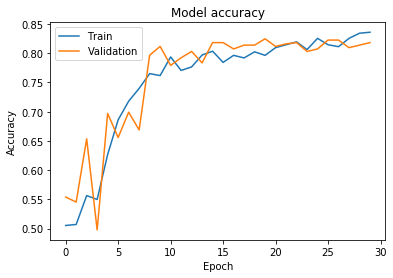

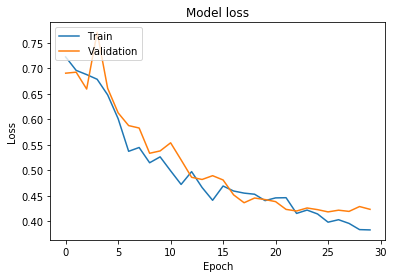

F1 score is:  0.82
Recall score is:  0.83
Precision score is:  0.82
Confusion matrix: 
 [[129  15]
 [ 37 107]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 37 false negatives and 107 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6453 - acc: 0.6315 - val_loss: 0.6912 - val_acc: 0.6277

Epoch 00001: val_loss improved from inf to 0.69116, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 67s 731ms/step - loss: 0.6257 - acc: 0.6771 - val_loss: 0.7469 - val_acc: 0.5325

Epoch 00002: val_loss did not 

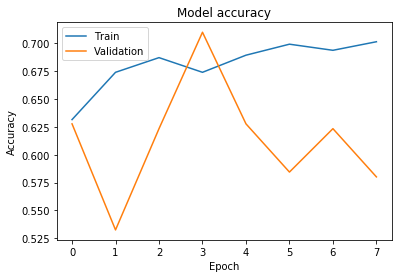

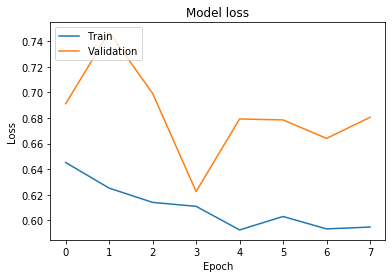

F1 score is:  0.7
Recall score is:  0.8
Precision score is:  0.72
Confusion matrix: 
 [[141   3]
 [ 77  67]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 77 false negatives and 67 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6886 - acc: 0.5326 - val_loss: 0.6529 - val_acc: 0.6169

Epoch 00001: val_loss improved from inf to 0.65290, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 718ms/step - loss: 0.6838 - acc: 0.5935 - val_loss: 0.5991 - val_acc: 0.6905

Epoch 00002: val_loss improved fro

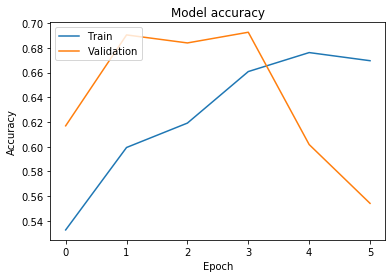

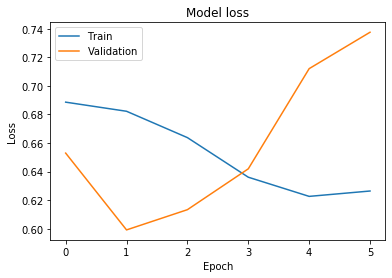

F1 score is:  0.68
Recall score is:  0.76
Precision score is:  0.7
Confusion matrix: 
 [[136   8]
 [ 78  66]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 78 false negatives and 66 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6900 - acc: 0.5815 - val_loss: 0.6825 - val_acc: 0.6970

Epoch 00001: val_loss improved from inf to 0.68252, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 720ms/step - loss: 0.6322 - acc: 0.6588 - val_loss: 0.7024 - val_acc: 0.6277

Epoch 00002: val_loss did not imp

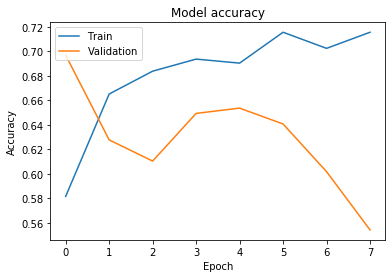

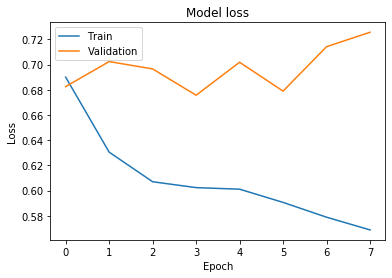

F1 score is:  0.64
Recall score is:  0.77
Precision score is:  0.67
Confusion matrix: 
 [[140   4]
 [ 91  53]]
From the confusion matrix above there are 140 true negatives and 4 false positives.
There are 91 false negatives and 53 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  77.49 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  78.82 %
F1 score is:  0.79
Recall score is:  0.79
Precision score is:  0.79
Confusion matrix: 
 [[107  37]
 [ 24 120]]
From the confusion matrix above there are 107 true negatives and 37 false positives.
There are 24 false negatives and 120 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   

   ResNet50 RI Seed 7 Dropout: 0.2 Test Acc  \
0                                     79.51   
1        


Epoch 00012: val_loss improved from 0.44462 to 0.43365, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 13/50
92/92 [==============================] - 29s 313ms/step - loss: 0.4529 - acc: 0.7892 - val_loss: 0.3769 - val_acc: 0.8052

Epoch 00013: val_loss improved from 0.43365 to 0.37691, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 14/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4452 - acc: 0.7968 - val_loss: 0.3783 - val_acc: 0.8095

Epoch 00014: val_loss did not improve from 0.37691
Epoch 15/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4714 - acc: 0.7892 - val_loss: 0.4253 - val_acc: 0.7965

Epoch 00015: val_loss did not improve from 0.37691
Epoch 16/50
92/92 [==============================] - 29s 313ms/step - loss: 0.4453 - acc: 0.8043 - val_loss: 0.4321 - val_acc: 0.8009

Epoch 00016: val_loss did not improve from 0.37691
Epoch 17/50
92/92 [===========================

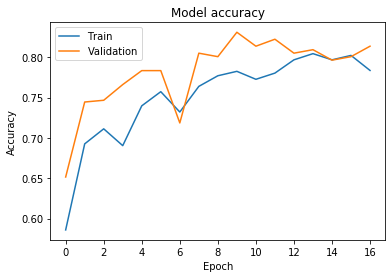

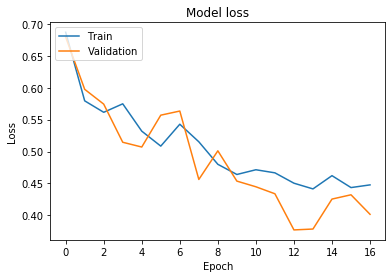

F1 score is:  0.79
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[120  24]
 [ 35 109]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 35 false negatives and 109 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 472ms/step - loss: 0.7287 - acc: 0.5576 - val_loss: 0.6949 - val_acc: 0.6299

Epoch 00001: val_loss improved from inf to 0.69493, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 314ms/step - loss: 0.6663 - acc: 0.6283 - val_loss: 0.6731 - val_acc: 0.7078

Epoch 00002: val_loss improved from 0.69493 to 0.

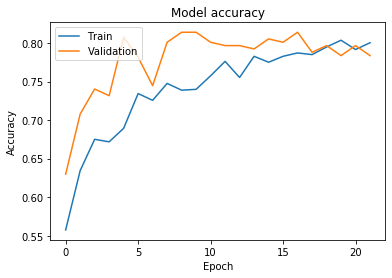

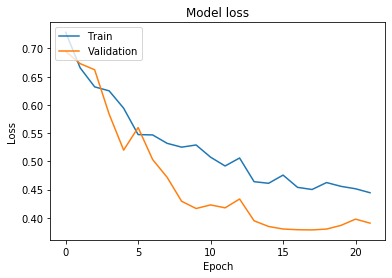

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[115  29]
 [ 23 121]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 23 false negatives and 121 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7231 - acc: 0.5141 - val_loss: 0.6834 - val_acc: 0.4286

Epoch 00001: val_loss improved from inf to 0.68335, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6963 - acc: 0.5358 - val_loss: 0.6928 - val_acc: 0.4113

Epoch 00002: val_loss did not improve from 0.68

Epoch 35/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5031 - acc: 0.7576 - val_loss: 0.4192 - val_acc: 0.7835

Epoch 00035: val_loss did not improve from 0.41905
Epoch 36/50
92/92 [==============================] - 29s 314ms/step - loss: 0.4968 - acc: 0.7577 - val_loss: 0.4128 - val_acc: 0.7965

Epoch 00036: val_loss improved from 0.41905 to 0.41283, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 37/50
92/92 [==============================] - 29s 313ms/step - loss: 0.4974 - acc: 0.7468 - val_loss: 0.4180 - val_acc: 0.7835

Epoch 00037: val_loss did not improve from 0.41283
Epoch 38/50
92/92 [==============================] - 29s 314ms/step - loss: 0.4797 - acc: 0.7706 - val_loss: 0.4141 - val_acc: 0.7922

Epoch 00038: val_loss did not improve from 0.41283
Epoch 39/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5128 - acc: 0.7523 - val_loss: 0.4121 - val_acc: 0.7879

Epoch 00039: val_loss improved from 0.4128

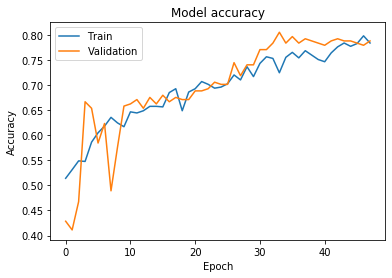

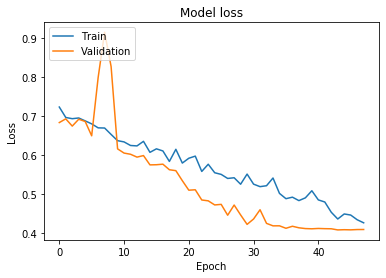

F1 score is:  0.79
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[104  40]
 [ 19 125]]
From the confusion matrix above there are 104 true negatives and 40 false positives.
There are 19 false negatives and 125 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7117 - acc: 0.5185 - val_loss: 0.6820 - val_acc: 0.5498

Epoch 00001: val_loss improved from inf to 0.68199, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 68s 734ms/step - loss: 0.6841 - acc: 0.5577 - val_loss: 0.6576 - val_acc: 0.6061

Epoch 00002: val_loss improved f

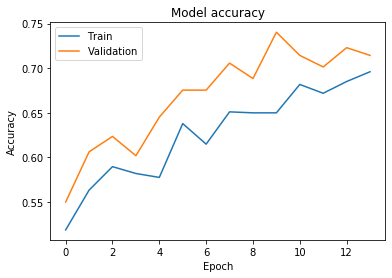

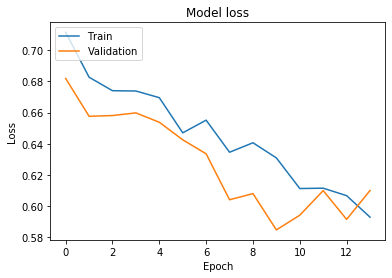

F1 score is:  0.73
Recall score is:  0.79
Precision score is:  0.74
Confusion matrix: 
 [[136   8]
 [ 67  77]]
From the confusion matrix above there are 136 true negatives and 8 false positives.
There are 67 false negatives and 77 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 114s 1s/step - loss: 0.6949 - acc: 0.5261 - val_loss: 0.6790 - val_acc: 0.5455

Epoch 00001: val_loss improved from inf to 0.67901, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 70s 756ms/step - loss: 0.7006 - acc: 0.5347 - val_loss: 0.7212 - val_acc: 0.5281

Epoch 00002: val_loss did not i

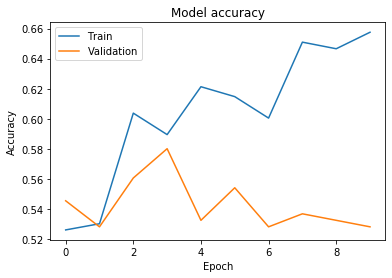

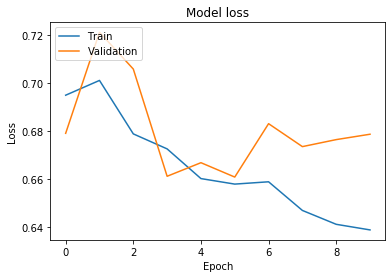

F1 score is:  0.5
Recall score is:  0.77
Precision score is:  0.58
Confusion matrix: 
 [[144   0]
 [120  24]]
From the confusion matrix above there are 144 true negatives and 0 false positives.
There are 120 false negatives and 24 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 100s 1s/step - loss: 0.7016 - acc: 0.5326 - val_loss: 0.6995 - val_acc: 0.5152

Epoch 00001: val_loss improved from inf to 0.69948, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 69s 752ms/step - loss: 0.7018 - acc: 0.5435 - val_loss: 0.6276 - val_acc: 0.6797

Epoch 00002: val_loss improved 

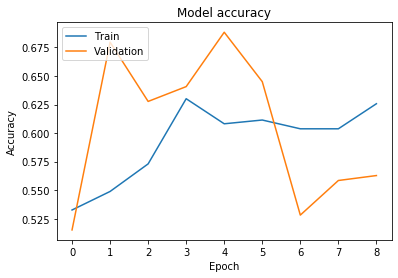

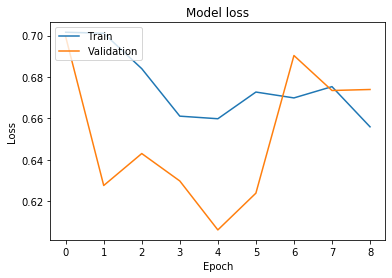

F1 score is:  0.65
Recall score is:  0.75
Precision score is:  0.67
Confusion matrix: 
 [[137   7]
 [ 87  57]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 87 false negatives and 57 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  80.09 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  81.25 %
F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[122  22]
 [ 32 112]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 32 false negatives and 112 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   
4       4                                    80.52   

   ResNet50 RI Seed 7 Dropout: 0.2 Test Acc  \
0 

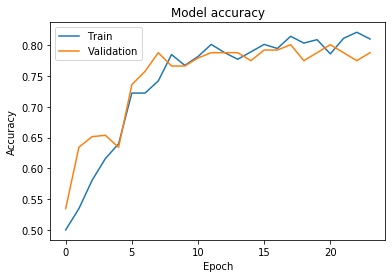

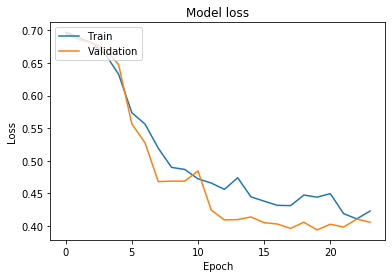

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[122  22]
 [ 30 114]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 30 false negatives and 114 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 472ms/step - loss: 0.7213 - acc: 0.4902 - val_loss: 0.6908 - val_acc: 0.5801

Epoch 00001: val_loss improved from inf to 0.69076, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 31s 339ms/step - loss: 0.6932 - acc: 0.5381 - val_loss: 0.6901 - val_acc: 0.7186

Epoch 00002: val_loss improved from 0.69076 to 

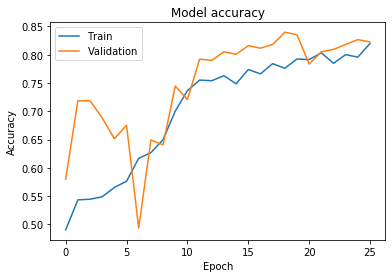

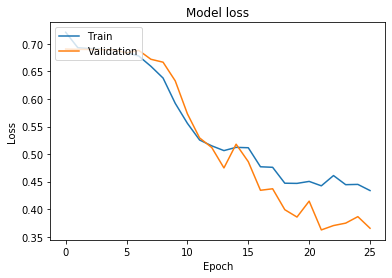

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[117  27]
 [ 25 119]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 25 false negatives and 119 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 44s 473ms/step - loss: 0.7256 - acc: 0.5826 - val_loss: 0.6830 - val_acc: 0.7532

Epoch 00001: val_loss improved from inf to 0.68301, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 33s 354ms/step - loss: 0.6537 - acc: 0.6532 - val_loss: 0.6622 - val_acc: 0.7641

Epoch 00002: val_loss improved from 0.68301 to 

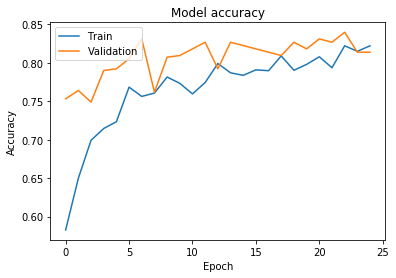

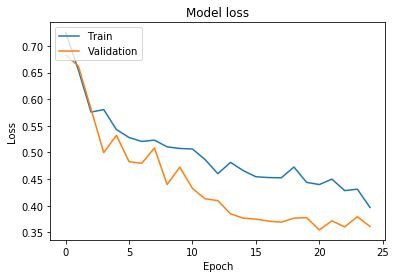

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[115  29]
 [ 21 123]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 21 false negatives and 123 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 100s 1s/step - loss: 0.6804 - acc: 0.5728 - val_loss: 0.5960 - val_acc: 0.7662

Epoch 00001: val_loss improved from inf to 0.59597, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 68s 744ms/step - loss: 0.6704 - acc: 0.5946 - val_loss: 0.6427 - val_acc: 0.6450

Epoch 00002: val_loss did not

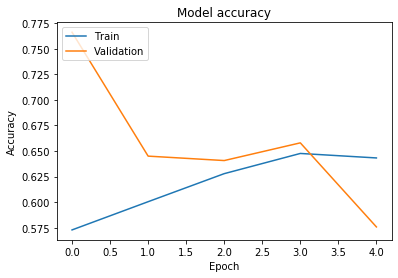

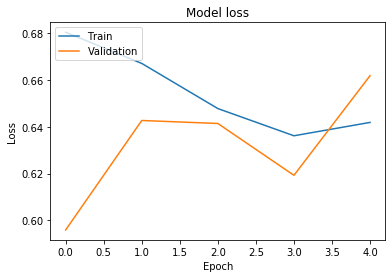

F1 score is:  0.76
Recall score is:  0.77
Precision score is:  0.76
Confusion matrix: 
 [[122  22]
 [ 46  98]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 46 false negatives and 98 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6849 - acc: 0.5804 - val_loss: 0.6473 - val_acc: 0.6494

Epoch 00001: val_loss improved from inf to 0.64730, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 67s 729ms/step - loss: 0.6812 - acc: 0.5859 - val_loss: 0.6032 - val_acc: 0.7056

Epoch 00002: val_loss improved 

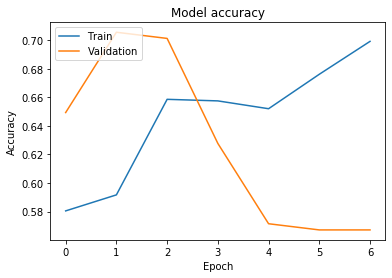

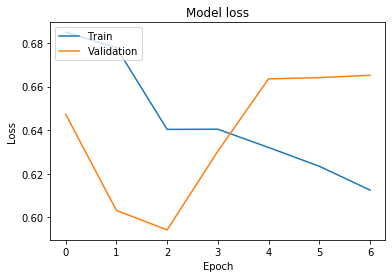

F1 score is:  0.65
Recall score is:  0.75
Precision score is:  0.68
Confusion matrix: 
 [[137   7]
 [ 86  58]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 86 false negatives and 58 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6743 - acc: 0.5391 - val_loss: 0.6196 - val_acc: 0.7013

Epoch 00001: val_loss improved from inf to 0.61961, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 67s 730ms/step - loss: 0.6615 - acc: 0.6066 - val_loss: 0.5513 - val_acc: 0.7403

Epoch 00002: val_loss improved f

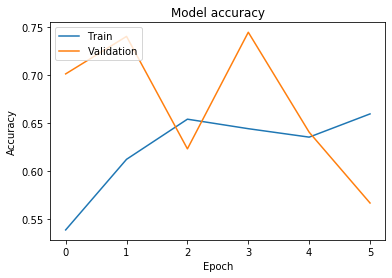

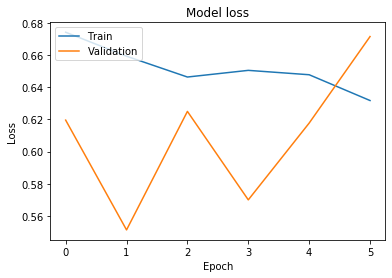

F1 score is:  0.75
Recall score is:  0.79
Precision score is:  0.76
Confusion matrix: 
 [[134  10]
 [ 59  85]]
From the confusion matrix above there are 134 true negatives and 10 false positives.
There are 59 false negatives and 85 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  80.95 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  82.99 %
F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[120  24]
 [ 25 119]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 25 false negatives and 119 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   
4       4                                    80.52   
5       5                                    78.7

Epoch 6/50
92/92 [==============================] - 30s 324ms/step - loss: 0.6394 - acc: 0.6479 - val_loss: 0.6547 - val_acc: 0.6061

Epoch 00006: val_loss improved from 0.68172 to 0.65466, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 7/50
92/92 [==============================] - 29s 314ms/step - loss: 0.6324 - acc: 0.6533 - val_loss: 0.6390 - val_acc: 0.6494

Epoch 00007: val_loss improved from 0.65466 to 0.63897, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 8/50
92/92 [==============================] - 29s 316ms/step - loss: 0.6257 - acc: 0.6684 - val_loss: 0.6090 - val_acc: 0.6580

Epoch 00008: val_loss improved from 0.63897 to 0.60900, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 9/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6338 - acc: 0.6566 - val_loss: 0.6086 - val_acc: 0.6494

Epoch 00009: val_loss improved from 0.60900 to 0.60858, saving model to ./

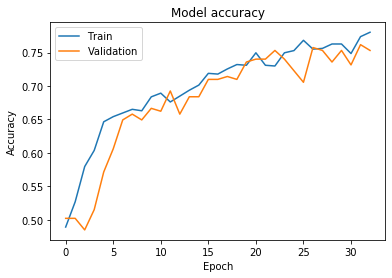

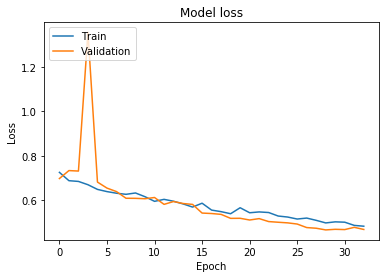

F1 score is:  0.78
Recall score is:  0.79
Precision score is:  0.78
Confusion matrix: 
 [[108  36]
 [ 26 118]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 26 false negatives and 118 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 470ms/step - loss: 0.6643 - acc: 0.6228 - val_loss: 0.6894 - val_acc: 0.7078

Epoch 00001: val_loss improved from inf to 0.68939, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 320ms/step - loss: 0.5472 - acc: 0.7358 - val_loss: 0.6720 - val_acc: 0.6970

Epoch 00002: val_loss improved from 0.68939 to 

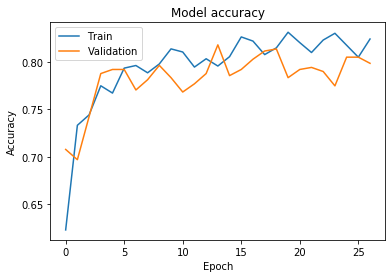

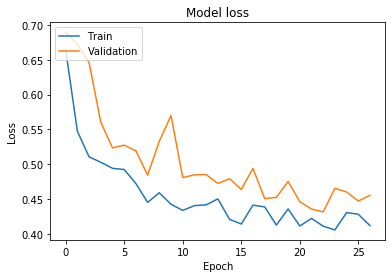

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[122  22]
 [ 30 114]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 30 false negatives and 114 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 471ms/step - loss: 0.7608 - acc: 0.5141 - val_loss: 0.9393 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.93928, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 314ms/step - loss: 0.6898 - acc: 0.5403 - val_loss: 0.6553 - val_acc: 0.5714

Epoch 00002: val_loss improved from 0.93928 to 

Epoch 33/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5103 - acc: 0.7587 - val_loss: 0.4871 - val_acc: 0.7273

Epoch 00033: val_loss did not improve from 0.48264
Epoch 34/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5016 - acc: 0.7598 - val_loss: 0.4825 - val_acc: 0.7273

Epoch 00034: val_loss improved from 0.48264 to 0.48250, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 35/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5157 - acc: 0.7305 - val_loss: 0.4766 - val_acc: 0.7532

Epoch 00035: val_loss improved from 0.48250 to 0.47663, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 36/50
92/92 [==============================] - 29s 312ms/step - loss: 0.4843 - acc: 0.7543 - val_loss: 0.4658 - val_acc: 0.7662

Epoch 00036: val_loss improved from 0.47663 to 0.46581, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 37/50
92/92 [

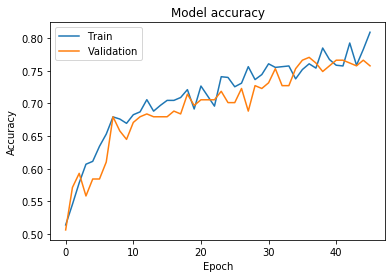

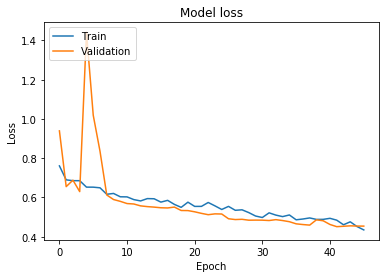

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[112  32]
 [ 25 119]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 25 false negatives and 119 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6829 - acc: 0.5587 - val_loss: 0.6366 - val_acc: 0.6407

Epoch 00001: val_loss improved from inf to 0.63658, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 67s 734ms/step - loss: 0.6635 - acc: 0.6077 - val_loss: 0.6983 - val_acc: 0.6537

Epoch 00002: val_loss did not imp

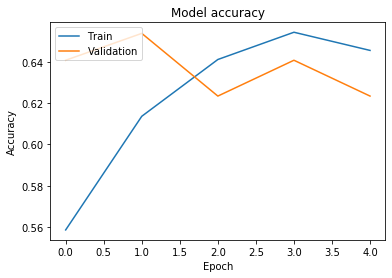

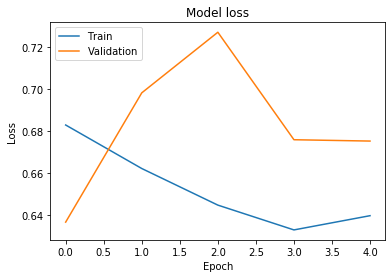

F1 score is:  0.59
Recall score is:  0.74
Precision score is:  0.64
Confusion matrix: 
 [[139   5]
 [100  44]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 100 false negatives and 44 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6935 - acc: 0.5467 - val_loss: 0.6270 - val_acc: 0.6558

Epoch 00001: val_loss improved from inf to 0.62697, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 67s 725ms/step - loss: 0.6660 - acc: 0.5946 - val_loss: 0.6386 - val_acc: 0.6320

Epoch 00002: val_loss did not i

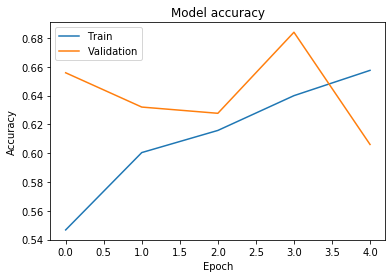

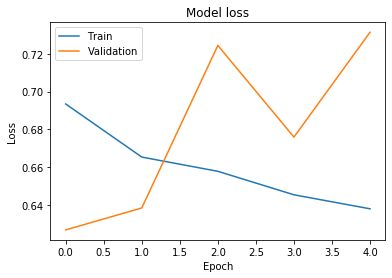

F1 score is:  0.59
Recall score is:  0.7
Precision score is:  0.63
Confusion matrix: 
 [[133  11]
 [ 96  48]]
From the confusion matrix above there are 133 true negatives and 11 false positives.
There are 96 false negatives and 48 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7015 - acc: 0.5250 - val_loss: 0.6451 - val_acc: 0.6558

Epoch 00001: val_loss improved from inf to 0.64505, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 707ms/step - loss: 0.7102 - acc: 0.4979 - val_loss: 0.6770 - val_acc: 0.5519

Epoch 00002: val_loss did not im

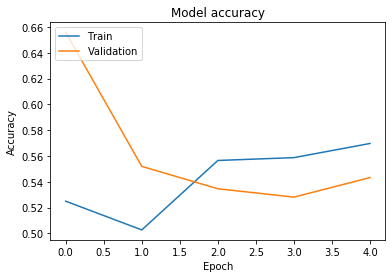

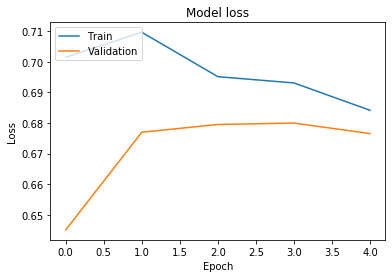

F1 score is:  0.64
Recall score is:  0.7
Precision score is:  0.66
Confusion matrix: 
 [[128  16]
 [ 83  61]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 83 false negatives and 61 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  77.92 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  81.6 %
F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[115  29]
 [ 24 120]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 24 false negatives and 120 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   
4       4                                    80.52   
5       5                                    78.79 

Epoch 2/50
92/92 [==============================] - 22s 235ms/step - loss: 0.6955 - acc: 0.4836 - val_loss: 0.6953 - val_acc: 0.4545

Epoch 00002: val_loss improved from 0.70022 to 0.69529, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6889 - acc: 0.5336 - val_loss: 0.6827 - val_acc: 0.5411

Epoch 00003: val_loss improved from 0.69529 to 0.68265, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 4/50
92/92 [==============================] - 29s 314ms/step - loss: 0.6627 - acc: 0.6010 - val_loss: 0.6025 - val_acc: 0.6753

Epoch 00004: val_loss improved from 0.68265 to 0.60245, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 5/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5687 - acc: 0.6989 - val_loss: 0.6467 - val_acc: 0.6991

Epoch 00005: val_loss did not improve from 0.60245
Epoch 6/50
92/92 [=====

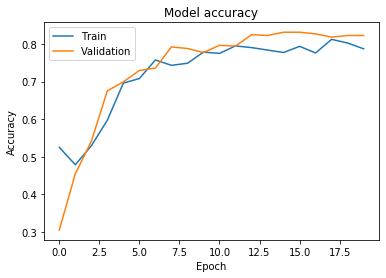

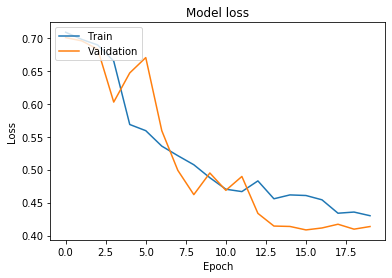

F1 score is:  0.82
Recall score is:  0.82
Precision score is:  0.82
Confusion matrix: 
 [[121  23]
 [ 28 116]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 28 false negatives and 116 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 466ms/step - loss: 0.6997 - acc: 0.4957 - val_loss: 0.6956 - val_acc: 0.5736

Epoch 00001: val_loss improved from inf to 0.69555, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6913 - acc: 0.5271 - val_loss: 0.6939 - val_acc: 0.6017

Epoch 00002: val_loss improved from 0.69555 to 

92/92 [==============================] - 29s 313ms/step - loss: 0.3810 - acc: 0.8240 - val_loss: 0.3888 - val_acc: 0.8355

Epoch 00034: val_loss did not improve from 0.38376
Epoch 35/50
92/92 [==============================] - 29s 313ms/step - loss: 0.3707 - acc: 0.8186 - val_loss: 0.3863 - val_acc: 0.8442

Epoch 00035: val_loss did not improve from 0.38376
Epoch 36/50
92/92 [==============================] - 29s 313ms/step - loss: 0.3540 - acc: 0.8348 - val_loss: 0.3836 - val_acc: 0.8398

Epoch 00036: val_loss improved from 0.38376 to 0.38365, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 37/50
92/92 [==============================] - 29s 313ms/step - loss: 0.3451 - acc: 0.8392 - val_loss: 0.3825 - val_acc: 0.8442

Epoch 00037: val_loss improved from 0.38365 to 0.38253, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 38/50
92/92 [==============================] - 29s 313ms/step - loss: 0.3406 - acc: 0.8543 - val_loss: 0

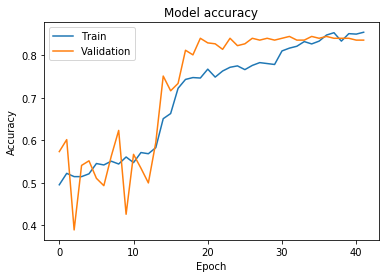

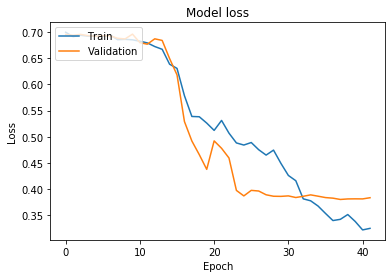

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[119  25]
 [ 24 120]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 24 false negatives and 120 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7318 - acc: 0.5543 - val_loss: 0.6888 - val_acc: 0.6515

Epoch 00001: val_loss improved from inf to 0.68883, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6803 - acc: 0.6087 - val_loss: 0.6832 - val_acc: 0.7208

Epoch 00002: val_loss improved from 0.68883 to 

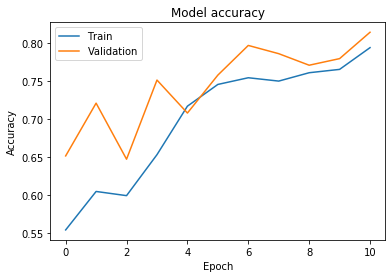

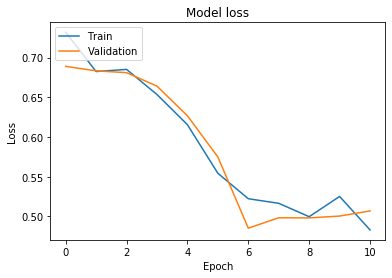

F1 score is:  0.78
Recall score is:  0.79
Precision score is:  0.78
Confusion matrix: 
 [[120  24]
 [ 38 106]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 38 false negatives and 106 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.6940 - acc: 0.5391 - val_loss: 0.6662 - val_acc: 0.6017

Epoch 00001: val_loss improved from inf to 0.66617, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 717ms/step - loss: 0.6585 - acc: 0.6054 - val_loss: 0.6909 - val_acc: 0.5065

Epoch 00002: val_loss did not 

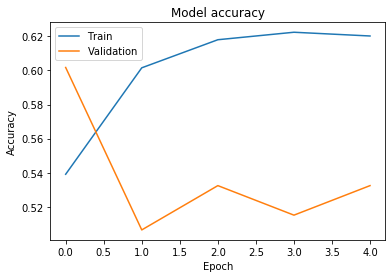

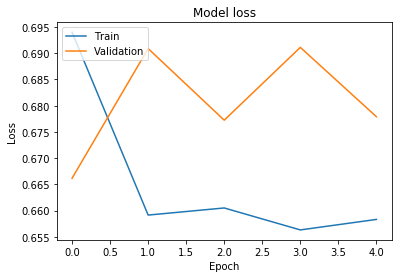

F1 score is:  0.5
Recall score is:  0.65
Precision score is:  0.57
Confusion matrix: 
 [[135   9]
 [115  29]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 115 false negatives and 29 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6997 - acc: 0.5500 - val_loss: 0.7079 - val_acc: 0.5628

Epoch 00001: val_loss improved from inf to 0.70788, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 721ms/step - loss: 0.6762 - acc: 0.6044 - val_loss: 0.6701 - val_acc: 0.6623

Epoch 00002: val_loss improved f

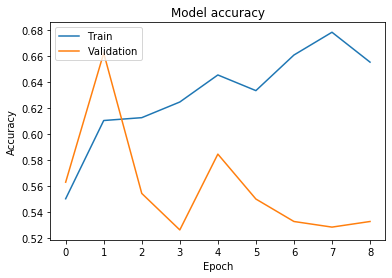

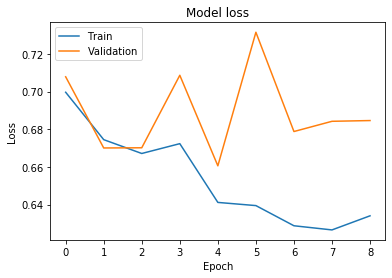

F1 score is:  0.51
Recall score is:  0.6
Precision score is:  0.56
Confusion matrix: 
 [[126  18]
 [109  35]]
From the confusion matrix above there are 126 true negatives and 18 false positives.
There are 109 false negatives and 35 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7074 - acc: 0.5500 - val_loss: 0.6526 - val_acc: 0.5974

Epoch 00001: val_loss improved from inf to 0.65255, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 64s 696ms/step - loss: 0.6747 - acc: 0.6065 - val_loss: 0.6277 - val_acc: 0.6147

Epoch 00002: val_loss improved 

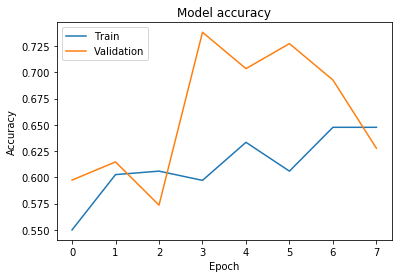

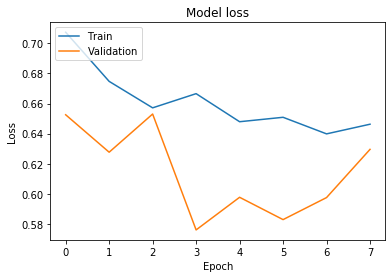

F1 score is:  0.72
Recall score is:  0.79
Precision score is:  0.73
Confusion matrix: 
 [[137   7]
 [ 70  74]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 70 false negatives and 74 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  81.82 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  83.33 %
F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[122  22]
 [ 26 118]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 26 false negatives and 118 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   
4       4                                    80.52   
5       5                                    78.79

ResNet50 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 469ms/step - loss: 0.7064 - acc: 0.5228 - val_loss: 0.6907 - val_acc: 0.5238

Epoch 00001: val_loss improved from inf to 0.69074, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6946 - acc: 0.5044 - val_loss: 0.6865 - val_acc: 0.6364

Epoch 00002: val_loss improved from 0.69074 to 0.68650, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6898 - acc: 0.5510 - val_loss: 0.6917 - val_acc: 0.5152

Epoch 00003: val_loss did not impr

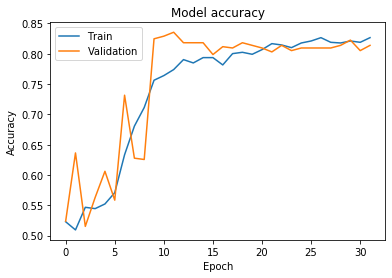

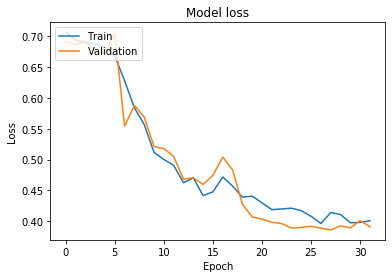

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[125  19]
 [ 30 114]]
From the confusion matrix above there are 125 true negatives and 19 false positives.
There are 30 false negatives and 114 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 471ms/step - loss: 0.7162 - acc: 0.5413 - val_loss: 0.6862 - val_acc: 0.7316

Epoch 00001: val_loss improved from inf to 0.68623, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6809 - acc: 0.6076 - val_loss: 0.6851 - val_acc: 0.5260

Epoch 00002: val_loss improved from 0.68623 to 

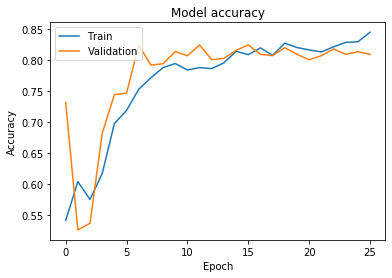

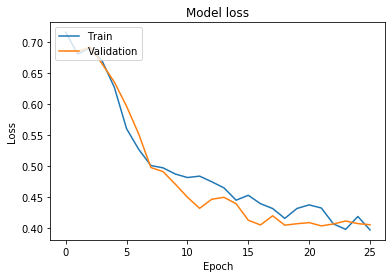

F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[122  22]
 [ 24 120]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 24 false negatives and 120 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7329 - acc: 0.5130 - val_loss: 0.6920 - val_acc: 0.6537

Epoch 00001: val_loss improved from inf to 0.69196, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6915 - acc: 0.5521 - val_loss: 0.6848 - val_acc: 0.7251

Epoch 00002: val_loss improved from 0.69196 to 

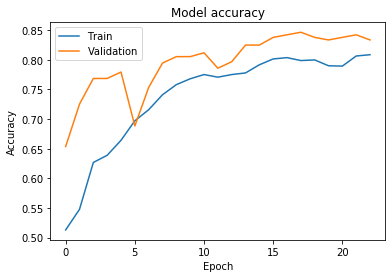

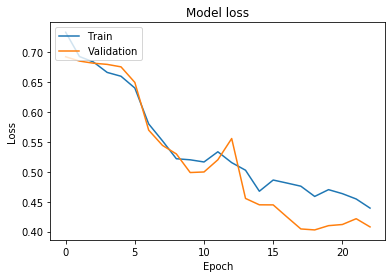

F1 score is:  0.79
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[122  22]
 [ 37 107]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 37 false negatives and 107 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.7264 - acc: 0.4783 - val_loss: 0.6929 - val_acc: 0.6494

Epoch 00001: val_loss improved from inf to 0.69295, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 714ms/step - loss: 0.6910 - acc: 0.5663 - val_loss: 0.6858 - val_acc: 0.6732

Epoch 00002: val_loss improved f

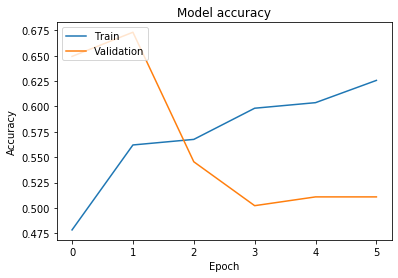

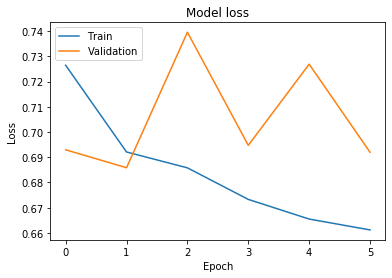

F1 score is:  0.63
Recall score is:  0.68
Precision score is:  0.65
Confusion matrix: 
 [[123  21]
 [ 81  63]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 81 false negatives and 63 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6792 - acc: 0.5902 - val_loss: 0.6796 - val_acc: 0.7013

Epoch 00001: val_loss improved from inf to 0.67961, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 66s 713ms/step - loss: 0.6570 - acc: 0.6251 - val_loss: 0.6244 - val_acc: 0.6926

Epoch 00002: val_loss improved 

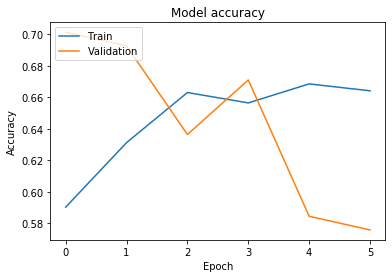

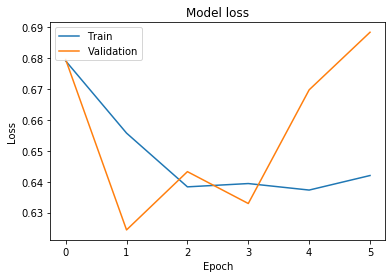

F1 score is:  0.69
Recall score is:  0.76
Precision score is:  0.71
Confusion matrix: 
 [[134  10]
 [ 74  70]]
From the confusion matrix above there are 134 true negatives and 10 false positives.
There are 74 false negatives and 70 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7084 - acc: 0.5163 - val_loss: 0.6939 - val_acc: 0.5714

Epoch 00001: val_loss improved from inf to 0.69394, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 703ms/step - loss: 0.6729 - acc: 0.5739 - val_loss: 0.6785 - val_acc: 0.5368

Epoch 00002: val_loss improved 

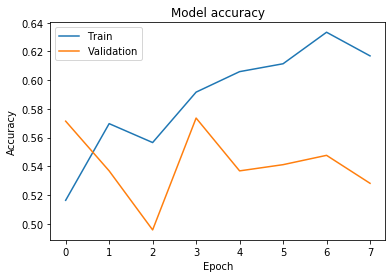

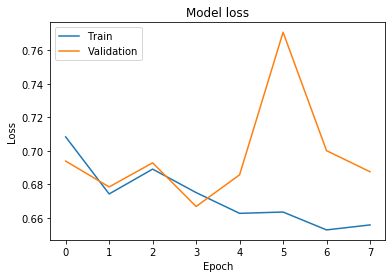

F1 score is:  0.49
Recall score is:  0.73
Precision score is:  0.58
Confusion matrix: 
 [[142   2]
 [120  24]]
From the confusion matrix above there are 142 true negatives and 2 false positives.
There are 120 false negatives and 24 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  80.95 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  83.68 %
F1 score is:  0.84
Recall score is:  0.84
Precision score is:  0.84
Confusion matrix: 
 [[123  21]
 [ 26 118]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 26 false negatives and 118 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   
4       4                                    80.52   
5       5                                    78.7

ResNet50 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 468ms/step - loss: 0.7405 - acc: 0.5261 - val_loss: 0.6917 - val_acc: 0.7056

Epoch 00001: val_loss improved from inf to 0.69169, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 312ms/step - loss: 0.6872 - acc: 0.5597 - val_loss: 0.6911 - val_acc: 0.6537

Epoch 00002: val_loss improved from 0.69169 to 0.69106, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 3/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6852 - acc: 0.5413 - val_loss: 0.6893 - val_acc: 0.6104

Epoch 00003: val_loss improved fro

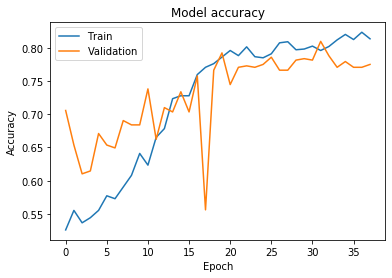

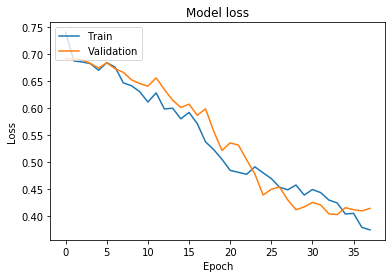

F1 score is:  0.83
Recall score is:  0.83
Precision score is:  0.83
Confusion matrix: 
 [[119  25]
 [ 24 120]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 24 false negatives and 120 true positives. 

ResNet50 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 470ms/step - loss: 0.7200 - acc: 0.5250 - val_loss: 1.0042 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 1.00417, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 29s 313ms/step - loss: 0.6847 - acc: 0.5816 - val_loss: 0.6711 - val_acc: 0.5974

Epoch 00002: val_loss improved from 1.00417 to 

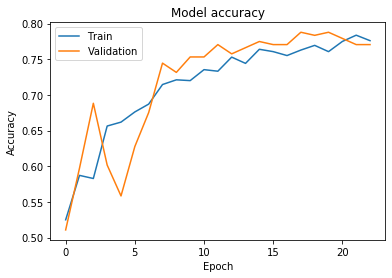

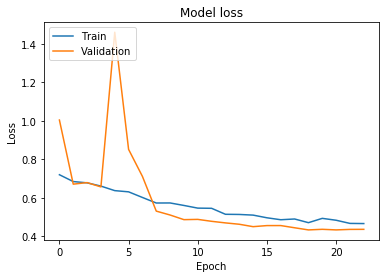

F1 score is:  0.79
Recall score is:  0.79
Precision score is:  0.79
Confusion matrix: 
 [[116  28]
 [ 33 111]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 33 false negatives and 111 true positives. 

ResNet50 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
92/92 [==============================] - 43s 467ms/step - loss: 0.7177 - acc: 0.5304 - val_loss: 0.6935 - val_acc: 0.5714

Epoch 00001: val_loss improved from inf to 0.69349, saving model to ./model/ResNet50 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 30s 323ms/step - loss: 0.6911 - acc: 0.5348 - val_loss: 0.6915 - val_acc: 0.5887

Epoch 00002: val_loss improved from 0.69349 to 

Epoch 32/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5455 - acc: 0.7490 - val_loss: 0.5294 - val_acc: 0.7446

Epoch 00032: val_loss did not improve from 0.51900
Epoch 33/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5934 - acc: 0.7490 - val_loss: 0.5374 - val_acc: 0.7532

Epoch 00033: val_loss did not improve from 0.51900
Epoch 34/50
92/92 [==============================] - 29s 314ms/step - loss: 0.5700 - acc: 0.7414 - val_loss: 0.5423 - val_acc: 0.7576

Epoch 00034: val_loss did not improve from 0.51900
Epoch 35/50
92/92 [==============================] - 29s 313ms/step - loss: 0.5444 - acc: 0.7425 - val_loss: 0.5396 - val_acc: 0.7532

Epoch 00035: val_loss did not improve from 0.51900
Epoch 00035: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 RI Seed 7 Dropout: 0.4 : Counter: 9, Accuracies: Validation: 75.32 %, Test: 78.82 %


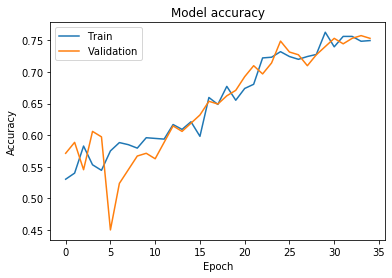

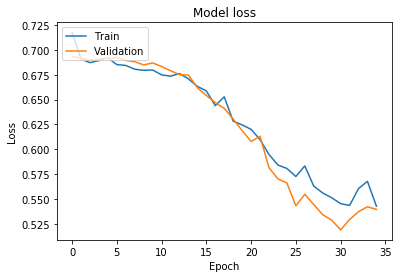

F1 score is:  0.79
Recall score is:  0.79
Precision score is:  0.79
Confusion matrix: 
 [[115  29]
 [ 32 112]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 32 false negatives and 112 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7003 - acc: 0.5065 - val_loss: 0.6895 - val_acc: 0.5216

Epoch 00001: val_loss improved from inf to 0.68955, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.2_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 707ms/step - loss: 0.6823 - acc: 0.5435 - val_loss: 0.6592 - val_acc: 0.6061

Epoch 00002: val_loss improved

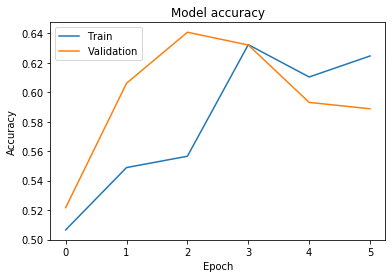

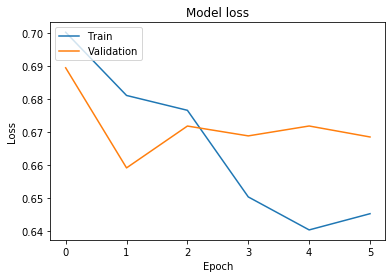

F1 score is:  0.6
Recall score is:  0.7
Precision score is:  0.63
Confusion matrix: 
 [[ 49  95]
 [ 11 133]]
From the confusion matrix above there are 49 true negatives and 95 false positives.
There are 11 false negatives and 133 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 98s 1s/step - loss: 0.7134 - acc: 0.5098 - val_loss: 0.6958 - val_acc: 0.4848

Epoch 00001: val_loss improved from inf to 0.69581, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.3_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 706ms/step - loss: 0.6894 - acc: 0.5576 - val_loss: 0.6786 - val_acc: 0.5022

Epoch 00002: val_loss improved fr

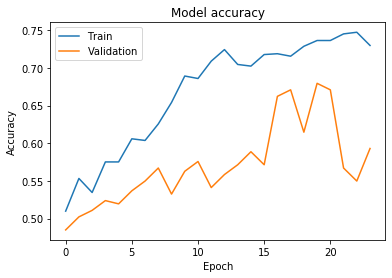

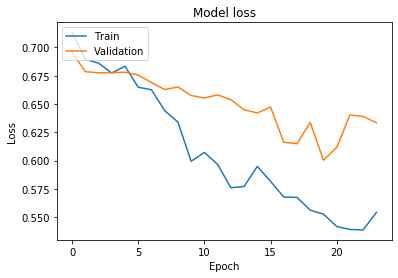

F1 score is:  0.62
Recall score is:  0.77
Precision score is:  0.66
Confusion matrix: 
 [[141   3]
 [ 95  49]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 95 false negatives and 49 true positives. 

EfficientNet B4 RI Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
92/92 [==============================] - 99s 1s/step - loss: 0.6980 - acc: 0.5478 - val_loss: 0.6774 - val_acc: 0.5671

Epoch 00001: val_loss improved from inf to 0.67740, saving model to ./model/EfficientNet B4 RI Seed 7 Dropout: 0.4_RI_bestmodel.hdf5
Epoch 2/50
92/92 [==============================] - 65s 705ms/step - loss: 0.6880 - acc: 0.5772 - val_loss: 0.6768 - val_acc: 0.5584

Epoch 00002: val_loss improved f

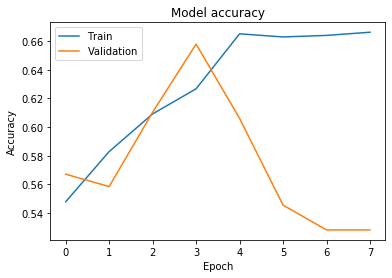

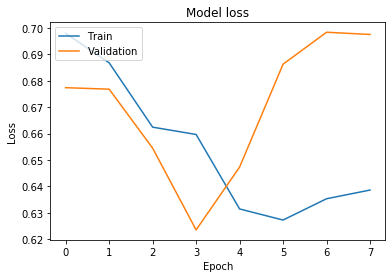

F1 score is:  0.65
Recall score is:  0.77
Precision score is:  0.68
Confusion matrix: 
 [[139   5]
 [ 88  56]]
From the confusion matrix above there are 139 true negatives and 5 false positives.
There are 88 false negatives and 56 true positives. 

Validation score of Ensemble of 1 & 2 Seed 7 RI:  76.62 %
Test score of Ensemble of 1 & 2 Seed 7 RI:  80.9 %
F1 score is:  0.81
Recall score is:  0.81
Precision score is:  0.81
Confusion matrix: 
 [[117  27]
 [ 28 116]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 28 false negatives and 116 true positives. 

results_data 

   Counter  ResNet50 RI Seed 7 Dropout: 0.2 Val Acc  \
0       0                                    81.82   
1       1                                    84.85   
2       2                                    84.42   
3       3                                    77.06   
4       4                                    80.52   
5       5                                    78.79 

2021-08-16 01:43:30.975917
Total running time (s): 60380 s
Total running time (min.s): 1006 min.s
Total running time (h): 16.77 hours


In [13]:
start = time.time()
print(datetime.now(), '\n', 'X, y shapes: ', X.shape, y.shape)

#float32 gives faster speed and negligible loss of precision
X = X.astype('float32')

#Split the data to get a hold out test set
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
num_splits = sss_initial.get_n_splits(X, y)

for train_val_index, test_index in sss_initial.split(X, y):
    #print('Train-Validation: ', train_val_index, 'Testing', test_index)

    X_train_val = X[train_val_index].copy()
    y_train_val = y[train_val_index].copy()

    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
    del X, y
    #Image preprocessing ResNet50
    X_resnet50_band_train_val = resnet.preprocess_input(X_train_val[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_train_val = resnet.preprocess_input(X_train_val[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_train_val processed: max, min', np.max(X_resnet50_band_train_val), np.min(X_resnet50_band_train_val))
    print('X_resnet50_rgb_train_val processed: max, min', np.max(X_resnet50_rgb_train_val), np.min(X_resnet50_rgb_train_val))
    X_resnet50_band_test = resnet.preprocess_input(X_test[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_test = resnet.preprocess_input(X_test[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_test processed: max, min', np.max(X_resnet50_band_test), np.min(X_resnet50_band_test))
    print('X_resnet50_rgb_test processed: max, min', np.max(X_resnet50_rgb_test), np.min(X_resnet50_rgb_test))
    
    X_effnet_band_train_val = X_train_val[:,:,:,0:3].copy()
    X_effnet_rgb_train_val = X_train_val[:,:,:,3:6].copy()
    X_effnet_band_test = X_test[:,:,:,0:3].copy()
    X_effnet_rgb_test = X_test[:,:,:,3:6].copy()
    
    #Image preprocessing EfficientNet B4
    image_size = 224
    
    for i in range(X_train_val.shape[0]):
        X_effnet_band_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_band_train_val[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_train_val[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_band_train_val[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_train_val[i,:,:,:]) #RGB Sentinel image 
    
    for i in range(X_test.shape[0]):
        X_effnet_band_test[i,:,:,:] = center_crop_and_resize(X_effnet_band_test[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_test[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_test[i,:,:,:] = efn.preprocess_input(X_effnet_band_test[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_test[i,:,:,:]) #RGB Sentinel image 
    print('X_effnet_bands_train_val processed: max, min', np.max(X_effnet_band_train_val), np.min(X_effnet_band_train_val))
    print('X_effnet_rgb_train_val processed: max, min', np.max(X_effnet_rgb_train_val), np.min(X_effnet_rgb_train_val))
    print('X_effnet_bands_test processed: max, min', np.max(X_effnet_band_test), np.min(X_effnet_band_test))
    print('X_effnet_rgb_test processed: max, min', np.max(X_effnet_rgb_test), np.min(X_effnet_rgb_test))

    del X_train_val, X_test
    
    results = trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, 
                         X_resnet50_rgb_test, y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, 
                         X_effnet_rgb_train_val, X_effnet_rgb_test)
    
#Save results to CSV
results.to_csv('./model/' + 'RI_Seed_7_Results.csv', sep=',', index=False)

end = time.time()
elapsed = end - start
print(datetime.now())
print('Total running time (s): %i s' % (elapsed))
print('Total running time (min.s): %i min.s' % (elapsed/60.0))
print('Total running time (h): %.2f hours' % (elapsed/3600.0))

## Note
- **The results are contained in the *'RI_Seed_7_Results.csv'* file in the *model* folder.**